In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.radarmodule as pyPIPSradar
import pyPIPS.PIPS as pips
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

init_radar_dict = init_radar_dict[casedate]
init_dis_dict = init_dis_dict[casedate]
init_model_dict = init_model_dict[casedate]

In [5]:
# Now go ahead and read in the sweeps for the desired case
radar_dict = sim.read_sweeps(init_radar_dict)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233553.663_to_20160331_234010.581_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:35:53 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223343.424_to_20160331_223746.038_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:33:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232035.774_to_20160331_232438.497_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:20:35 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225416.507_to_20160331_225824.478_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:54:16 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231525.783_to_20160331_231933.619_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:15:25 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_225928.203_to_20160331_230336.351_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:59:28 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_231009.612_to_20160331_231422.770_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:10:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_223849.284_to_20160331_224244.646_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 22:38:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222409.899_to_20160331_222745.586_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:24:09 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220855.137_to_20160331_221221.493_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:08:55 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_230443.929_to_20160331_230904.369_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.8129883
Time of sweep =  2016-03-31 23:04:43 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220034.035_to_20160331_220342.729_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:00:34 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224910.491_to_20160331_225313.332_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:49:10 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_233044.114_to_20160331_233446.376_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 23:30:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_232540.010_to_20160331_232942.705_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.83496094
Time of sweep =  2016-03-31 23:25:40 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221324.459_to_20160331_221637.372_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:13:24 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_220444.462_to_20160331_220752.822_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:04:44 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_222848.491_to_20160331_223242.346_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:28:48 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_221946.379_to_20160331_222307.878_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:19:46 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_3/KGWX/CFRadial/cfrad.20160331_224349.896_to_20160331_224806.980_KGWX_Surveillance_SUR.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  0.87890625
Time of sweep =  2016-03-31 22:43:49 
Number of gates:  1832
Radar lat,lon,alt [33.89691544] [-88.32919312] [179.]
Gatewidth  250.0
Radar beam width (degrees): 0.89
Number of azimuths in sweep  720


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


310316 221203
2016-03-31 22:12:00
2016 3 31 22 12 0
2016-03-31 22:12:03 2016-03-31 22:12:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 220133
2016-03-31 22:01:30
2016 3 31 22 1 30
2016-03-31 22:01:33 2016-03-31 22:01:30
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 222503
2016-03-31 22:25:00
2016 3 31 22 25 0
2016-03-31 22:25:03 2016-03-31 22:25:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 214823
2016-03-31 21:48:20
2016 3 31 21 48 20
2016-03-31 21:48:23 2016-03-31 21:48:20
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested D

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/xarray.py:435: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/calc/basic.py:797: RuntimeWarning: All-NaN slice encountered
  if np.greater(np.nanmax(np.abs(value)), max_radians):
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/metpy/plots/_mpl.py:331: MatplotlibDeprecationWarning: 
The is_math_text function was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  clean_line, ismath = self.is_math_text(line)


i, sweeptime =  2016-03-31 22:04:44
i, sweeptime =  2016-03-31 22:08:55
i, sweeptime =  2016-03-31 22:13:24
i, sweeptime =  2016-03-31 22:19:46
i, sweeptime =  2016-03-31 22:24:09
i, sweeptime =  2016-03-31 22:28:48
i, sweeptime =  2016-03-31 22:33:43
i, sweeptime =  2016-03-31 22:38:49
i, sweeptime =  2016-03-31 22:43:49
i, sweeptime =  2016-03-31 22:49:10
i, sweeptime =  2016-03-31 22:54:16
i, sweeptime =  2016-03-31 22:59:28
i, sweeptime =  2016-03-31 23:04:43
i, sweeptime =  2016-03-31 23:10:09
i, sweeptime =  2016-03-31 23:15:25
i, sweeptime =  2016-03-31 23:20:35
i, sweeptime =  2016-03-31 23:25:40
i, sweeptime =  2016-03-31 23:30:44
i, sweeptime =  2016-03-31 23:35:53


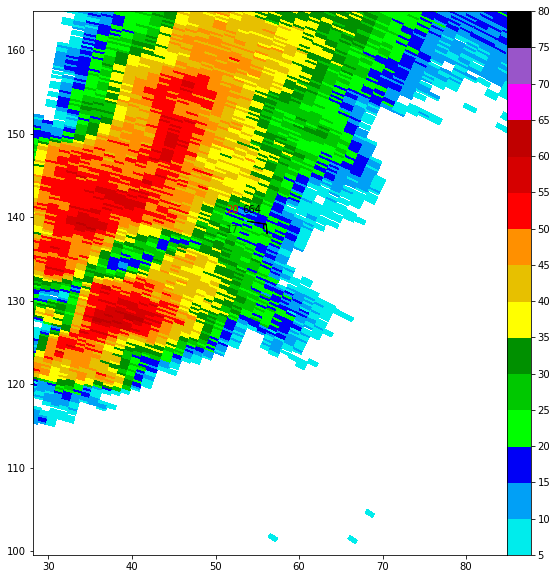

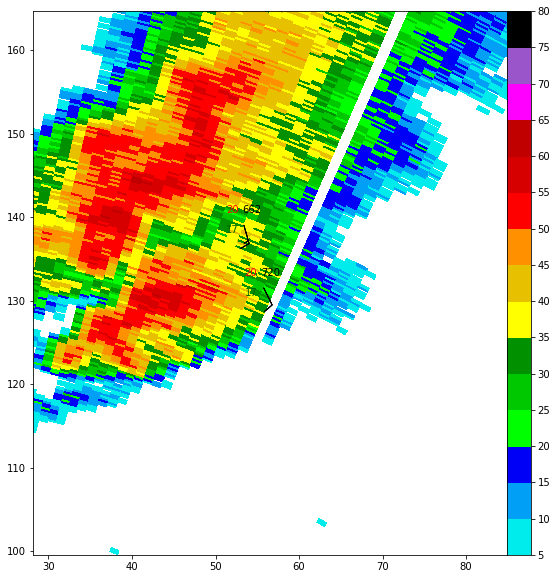

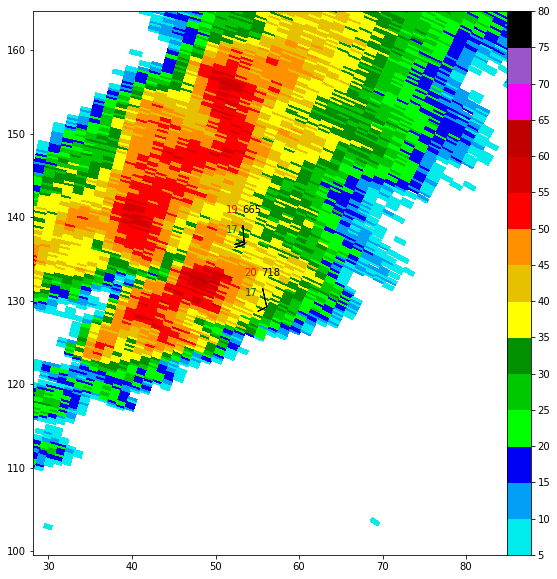

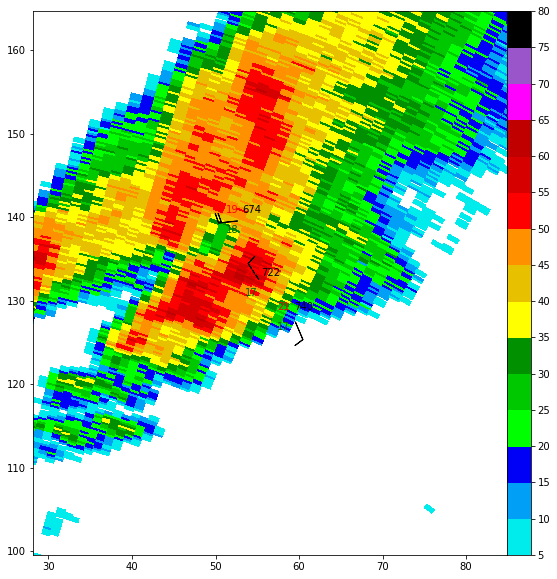

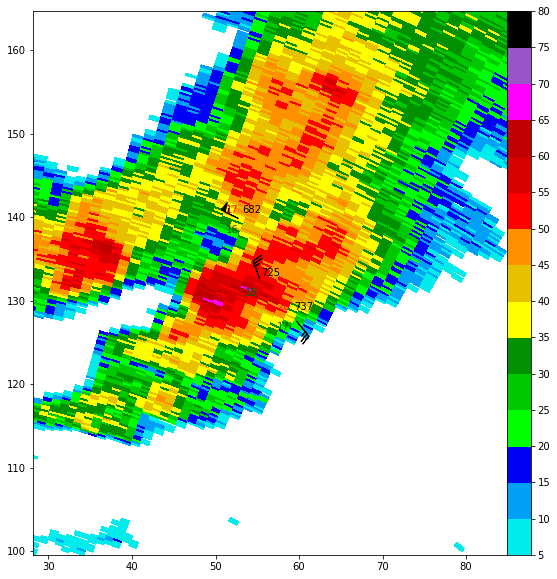

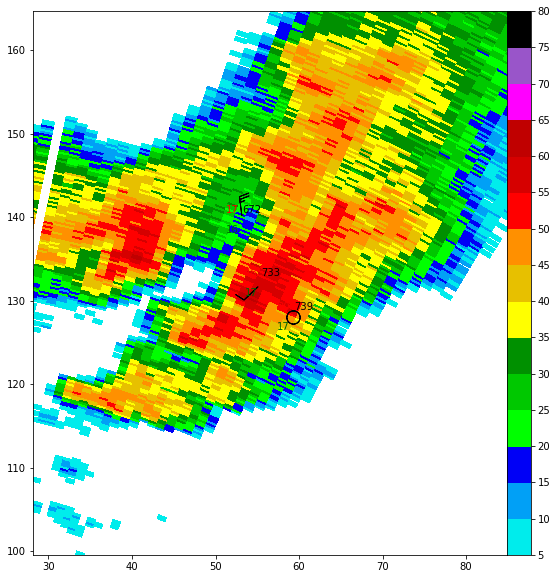

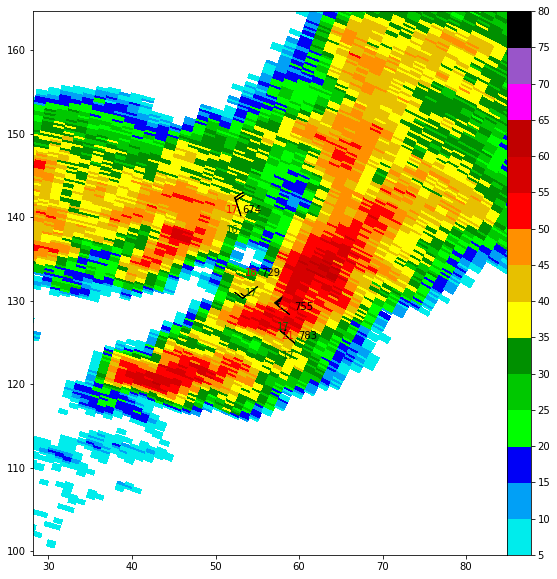

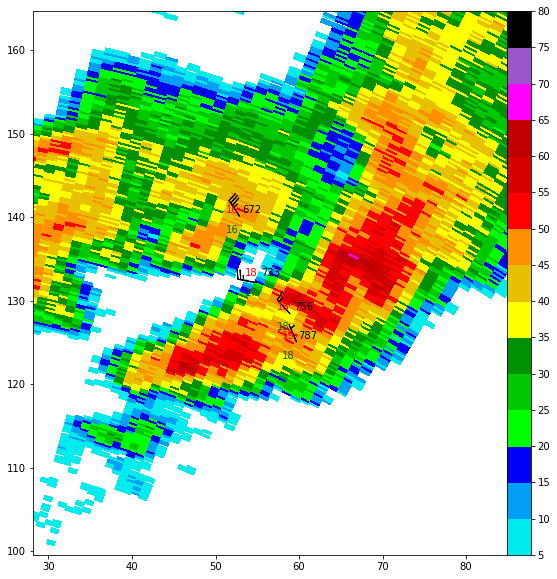

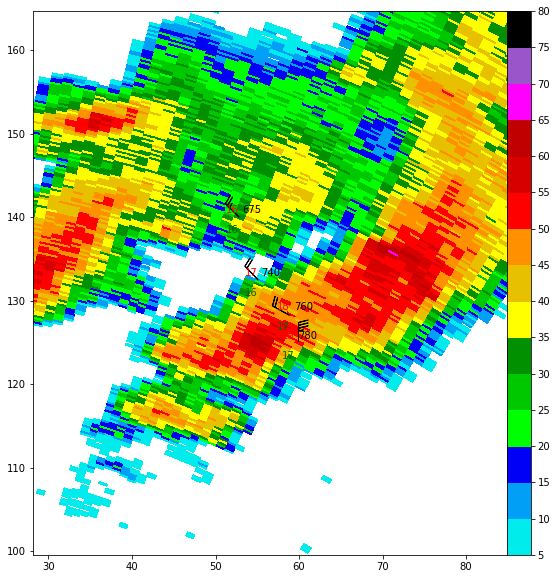

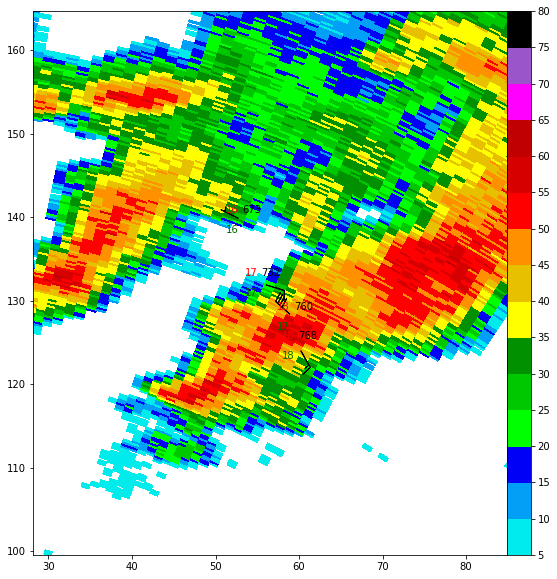

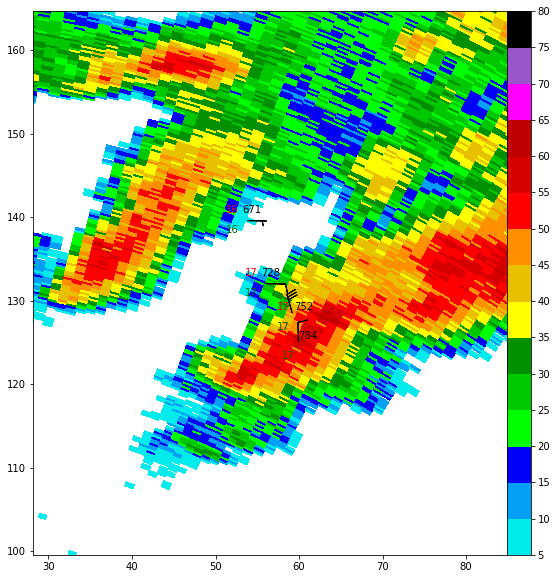

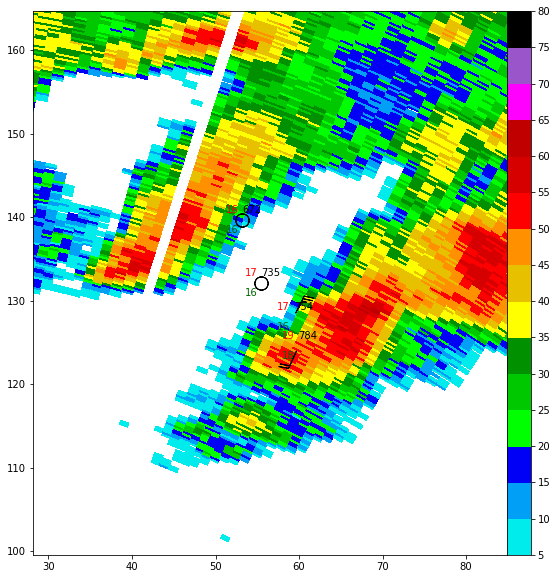

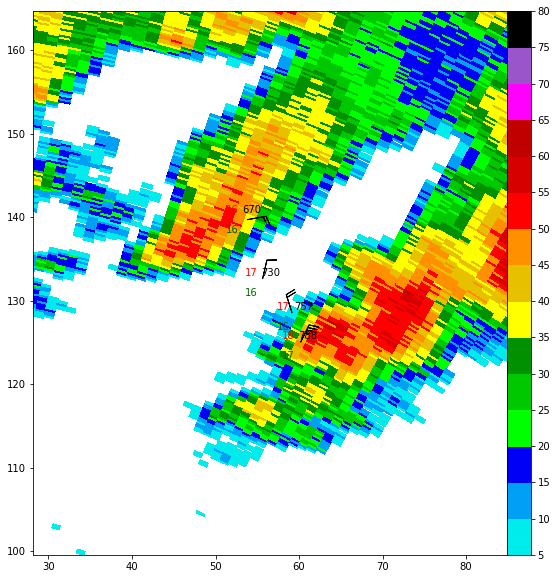

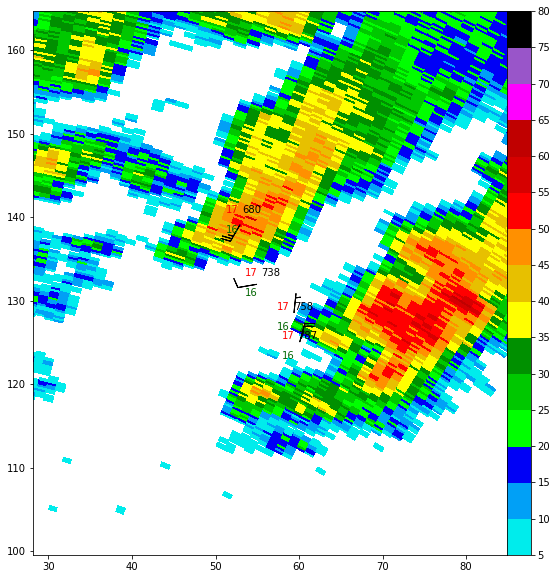

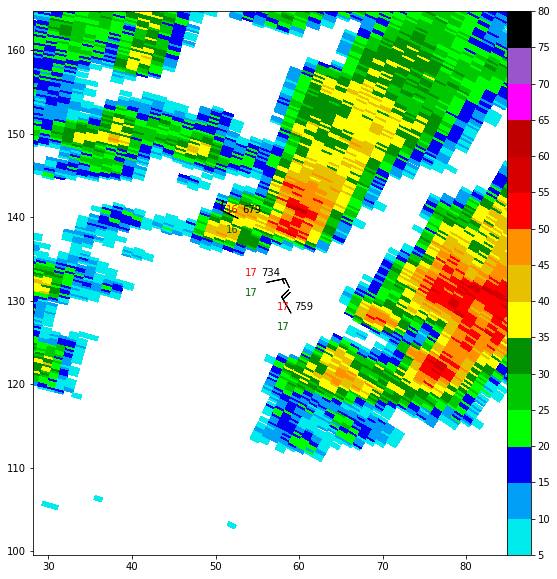

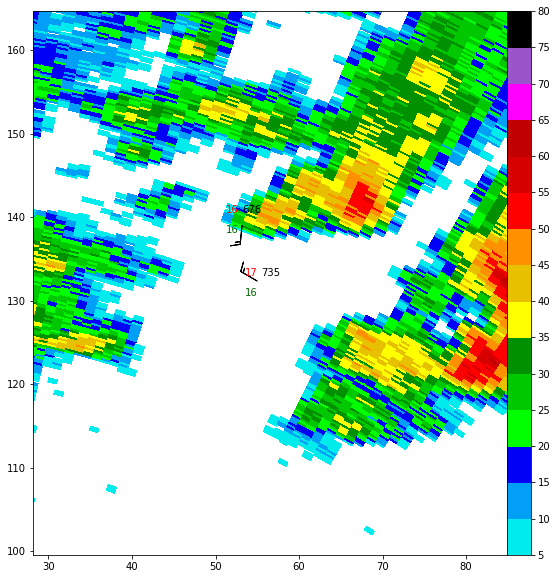

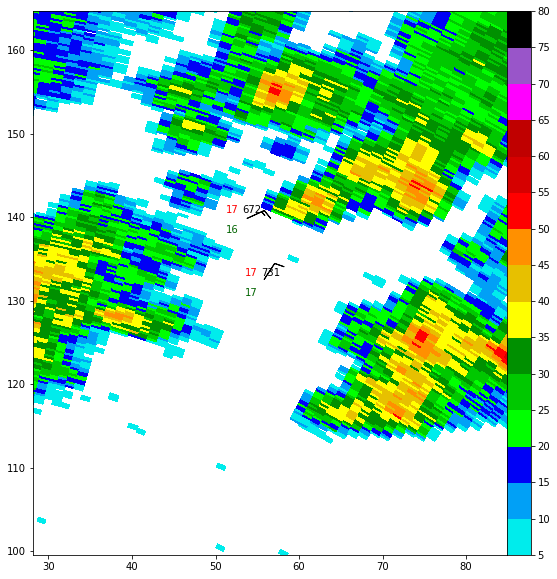

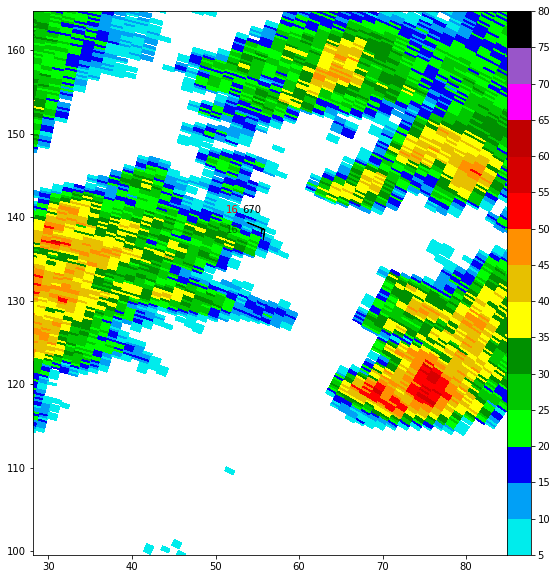

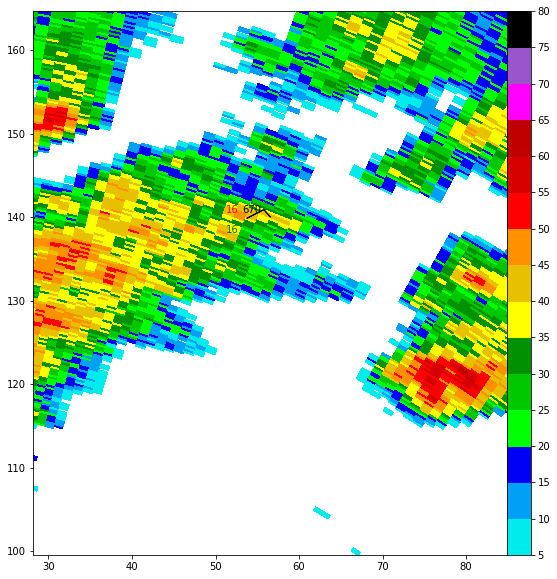

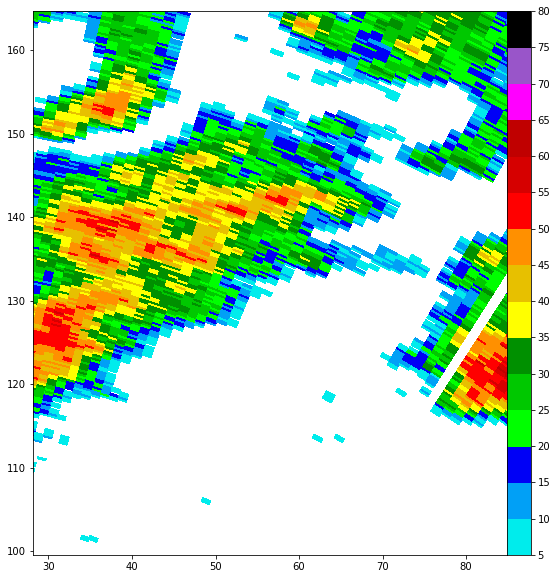

In [6]:
# Go ahead and read in the conventional data at the sweeptimes and plot them:
# %matplotlib notebook
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots'
radlims = [0.0, 250000., 0., 360.]
plotlims = [-1, -1, -1, -1]
ovrmap = False # Currently not working
ovrdis = False
dis_name_list = None
dxy_list = None
fields_D_list = None
deg2rad = np.pi / 180.

# Read time series
dis_dict_at_radar = sim.read_convdata_at_sweeptimes(init_dis_dict, radar_dict)

# Find disdrometer lat/lons and convert them to cartesian coordinates relative to radar lat/lon

dis_dict = sim.get_dis_locs_relative_to_radar(init_dis_dict, radar_dict)

dxlist = [i[0] for i in dis_dict['dradloclist']]
dylist = [i[1] for i in dis_dict['dradloclist']]

# Set plotting limits to center on the disdrometer locations 
if plotlims[0] == -1:
    Dxmin = min(dxlist)
    Dxmax = max(dxlist)
    Dymin = min(dylist)
    Dymax = max(dylist)
    plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

# Extract stuff from radar dictionary
sweeptimelist = radar_dict['sweeptimelist']
radarsweeplist = radar_dict['radarsweeplist']
outfieldnames = radar_dict['outfieldnameslist'][0] # Just need first entry

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_radar['convdata_at_sweeptimes']['temp']
dewpointlist = dis_dict_at_radar['convdata_at_sweeptimes']['dewpoint']
pressurelist = dis_dict_at_radar['convdata_at_sweeptimes']['pressure']
windspdavgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_radar['convdata_at_sweeptimes']['winddiravgvec']


for i, sweeptime in enumerate(sweeptimelist):
    print("i, sweeptime = ", sweeptime)
    figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
                                                    ovrdis, dis_name_list, dxy_list, fields_D_list)
    ax = gridlist[0][0]
    
    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='red')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

    figlist[0].canvas.draw()
    figlist[0].set_size_inches(10., 10., forward = True)
    figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [7]:
# Now do the same for the model output
# First set up some stuff

def get_ARPS_member_dir_and_prefix(member, cycle):
    """
    Gets the proper form for the subdirectory and file prefix name given a member number
    and cycle type (either 'posterior' or 'prior'). member number 0 is interpreted as the mean. 
    """
    if member == 0:
        if cycle in 'posterior':
            member_dir = 'ENamean'
            member_prefix = 'enmean'
        elif cycle in 'prior':
            member_dir = 'ENfmean'
            member_prefix = 'efmean'
    else:
        if cycle in 'posterior':
            member_dir = 'EN{:03d}'.format(int(member))
            member_prefix = 'ena{:03d}'.format(int(member))
        elif cycle in 'prior':
            member_dir = 'ENF{:03d}'.format(int(member))
            member_prefix = 'enf{:03d}'.format(int(member))
    
    return member_dir, member_prefix

modelname = 'ARPS'
microphys = 'ZVD'

# From desired start and end times (UTC) get a range of datetimes and corresponding range of times in
# seconds since model initial time
timestamp_model_init = init_model_dict['timestamp_model_init']  # Start time of model corresponding to 0 s
datetime_model_init = datetime.strptime(timestamp_model_init, '%Y%m%d%H%M%S')

timestamp_start = init_model_dict['timestamp_model_start']  # Start time of desired time window
timestamp_stop = init_model_dict['timestamp_model_stop']  # Stop time of desired time window
datetime_start = datetime.strptime(timestamp_start, '%Y%m%d%H%M%S')
datetime_stop = datetime.strptime(timestamp_stop, '%Y%m%d%H%M%S')
tintv = init_model_dict['model_dt']  # Interval in seconds for model output
tintv_mean = init_model_dict['model_dt_mean'] # Interval in seconds for ensemble mean analysis

datetime_range = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv)
trange = CRMutils.modeltimes_from_datetimes(datetime_range, datetime_start=datetime_model_init)

datetime_range_mean = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv_mean)
trange_mean = CRMutils.modeltimes_from_datetimes(datetime_range_mean, datetime_start=datetime_model_init)

#basedir = '/Volumes/scr_fast/Projects/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540'
fileformat = init_model_dict['fileformat']
expname = '1km453x453_newse'
basedir = init_model_dict['basedirname']
member = 1 # 0 is for ensemble mean
cycle = 'posterior'
member_dir, member_prefix = get_ARPS_member_dir_and_prefix(member, cycle)
member_absdir = os.path.join(basedir, expname, member_dir)
trailer = ''
nproc_x = 15
nproc_y = 6

# Tell the arps_read module what the processor numbers are.
# Yes, I know this is a bad way to do this through globals. I'll fix it eventually.
arps_read.nproc_x = nproc_x
arps_read.nproc_y = nproc_y

if member == 0:
    model_trange_sec = trange_mean
    model_datetime_range = datetime_range_mean
else:
    model_trange_sec = trange
    model_datetime_range = datetime_range
    
model_dict = init_model_dict.copy()

model_dict['trange_member'] = trange
model_dict['trange_mean'] = trange_mean
model_dict['datetime_range_member'] = datetime_range
model_dict['datetime_range_mean'] = datetime_range_mean


if member == 0:
    model_dict['trange'] = trange_mean
    model_dict['datetime_range'] = datetime_range_mean
else:
    model_dict['trange'] = trange
    model_dict['datetime_range'] = datetime_range
    
print(model_datetime_range)

[datetime.datetime(2016, 3, 31, 22, 0), datetime.datetime(2016, 3, 31, 22, 5), datetime.datetime(2016, 3, 31, 22, 10), datetime.datetime(2016, 3, 31, 22, 15), datetime.datetime(2016, 3, 31, 22, 20), datetime.datetime(2016, 3, 31, 22, 25), datetime.datetime(2016, 3, 31, 22, 30), datetime.datetime(2016, 3, 31, 22, 35), datetime.datetime(2016, 3, 31, 22, 40), datetime.datetime(2016, 3, 31, 22, 45), datetime.datetime(2016, 3, 31, 22, 50), datetime.datetime(2016, 3, 31, 22, 55), datetime.datetime(2016, 3, 31, 23, 0), datetime.datetime(2016, 3, 31, 23, 5), datetime.datetime(2016, 3, 31, 23, 10), datetime.datetime(2016, 3, 31, 23, 15), datetime.datetime(2016, 3, 31, 23, 20), datetime.datetime(2016, 3, 31, 23, 25), datetime.datetime(2016, 3, 31, 23, 30), datetime.datetime(2016, 3, 31, 23, 35), datetime.datetime(2016, 3, 31, 23, 40)]


In [9]:
# Load the ARPS grid
# Get file path for grdbas file (note that call to read_grid handles the reading of the individual patches)
# If the grdbas file doesn't exist, fall back to a history file
grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, filetype='grdbas')

patch_x = 1
patch_y = 1
grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

if not os.path.exists(grdbas_path_test):
    print("grdbas file doesn't exist, trying a history file!")
    grdbas_path = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=model_trange_sec[0], 
                                          filetype='history')
    grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

    print(grdbas_path_test)
    print(os.path.exists(grdbas_path_test))

# Read in grid information
grid_dict = arps_read.readarpsgrid(grdbas_path)
print(grid_dict.keys())

# Get map projection information and create a Basemap instance
# TODO: convert to use cartopy!

ctrlat, ctrlon, trulat1, trulat2, trulon = arps_read.readarpsmap(grdbas_path)

dx = grid_dict['dx']
dy = grid_dict['dy']
nx = grid_dict['nx']
ny = grid_dict['ny']

mapwidth = nx * dx
mapheight = ny * dy

bgmap = Basemap(projection='lcc', width=mapwidth, height=mapheight, lat_1=trulat1,
                lat_2=trulat2, lat_0=ctrlat, lon_0=ctrlon, resolution='h',
                area_thresh=10., suppress_ticks=False)



dict_keys(['nx', 'ny', 'nz', 'dx', 'dy', 'dz', 'x', 'y', 'z', 'zp', 'xs', 'ys', 'zs', 'zpagl', 'zsagl'])


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [10]:
# Put the basemap instance into the grid_dict
grid_dict['bgmap'] = bgmap

# Find coordinates of PIPS stations in the model
dis_dict = sim.get_dis_locs_arps_real_grid(dis_dict, grid_dict)


coord_array = np.array(dis_dict['dmodcrdlist'])

print(coord_array) 
print(coord_array.shape) 
print(coord_array[0]) 
# coord_array = coord_array.T

[[226.22825433 253.40098553]
 [222.37480154 257.58480521]
 [226.75691376 249.97353499]
 [220.16784265 265.07492488]]
(4, 2)
[226.22825433 253.40098553]


[226.2282543262902, 222.37480154110668, 226.75691376130987, 220.1678426462494]
[253.40098552587978, 257.58480521031026, 249.97353498544854, 265.074924876145]
[226728.2543262902, 222874.8015411067, 227256.91376130987, 220667.8426462494]
[253900.98552587978, 258084.80521031027, 250473.53498544852, 265574.924876145]
[195667.8426462494, 252256.91376130987, 225473.53498544852, 290574.924876145]
197 254 226 293
310316 221203
2016-03-31 22:12:00
2016 3 31 22 12 0
2016-03-31 22:12:03 2016-03-31 22:12:00
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 220133
2016-03-31 22:01:30
2016 3 31 22 1 30
2016-03-31 22:01:33 2016-03-31 22:01:30
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0
310316 222503
2016-03-

needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  18000.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf018000
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'dBZmod'}
retrieved fields:  dict_keys(['dBZmod'])
axis_names:  ('x', 'y')
xlim, ylim:  (195667.8426462494, 252256.91376130987) (225473.53498544852, 290574.924876145)
Loading time  18300.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf018300
field names (before):  ['dBZmod']
field names (after):  ['dBZmod']
needed_variables (before):  {'dBZmod'}
existing var

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


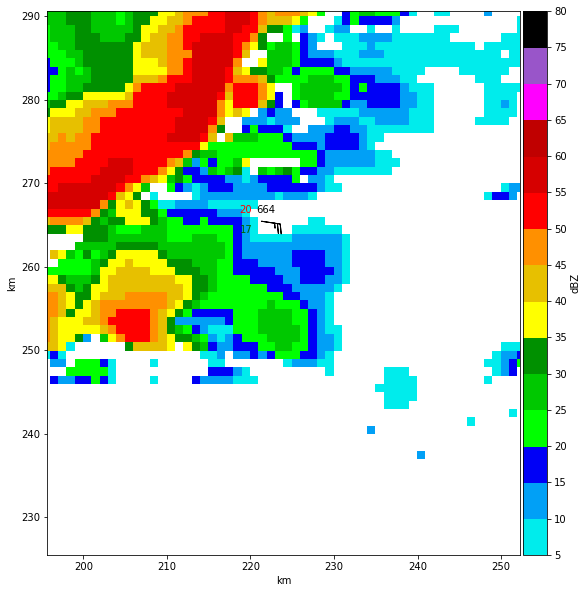

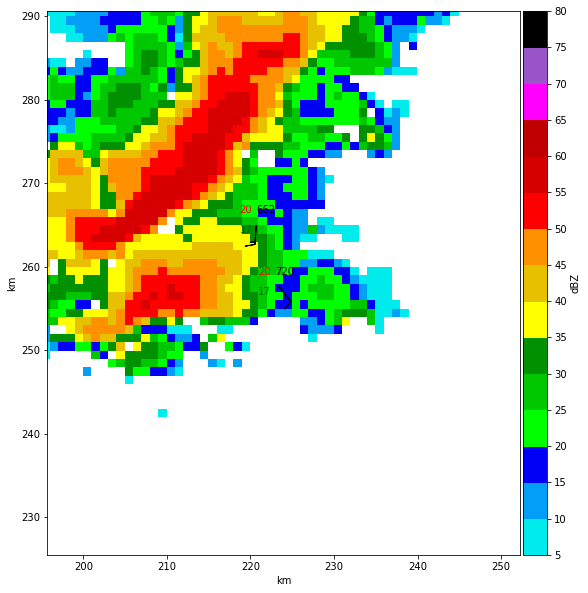

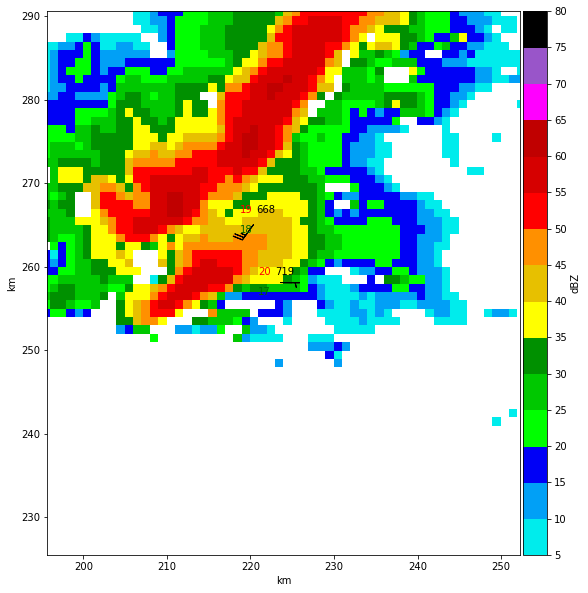

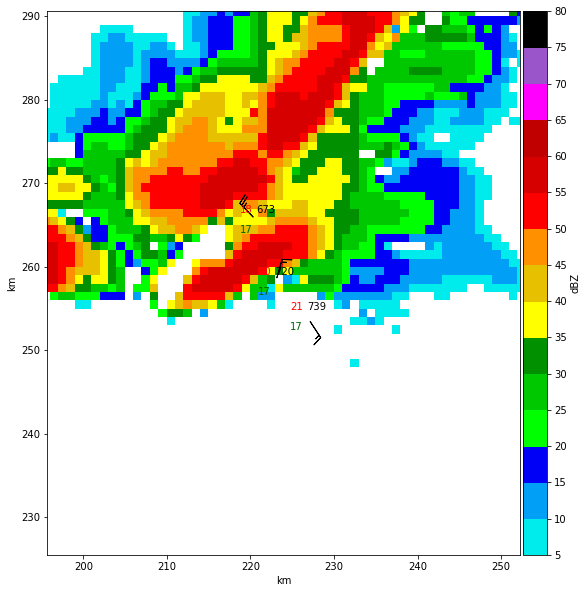

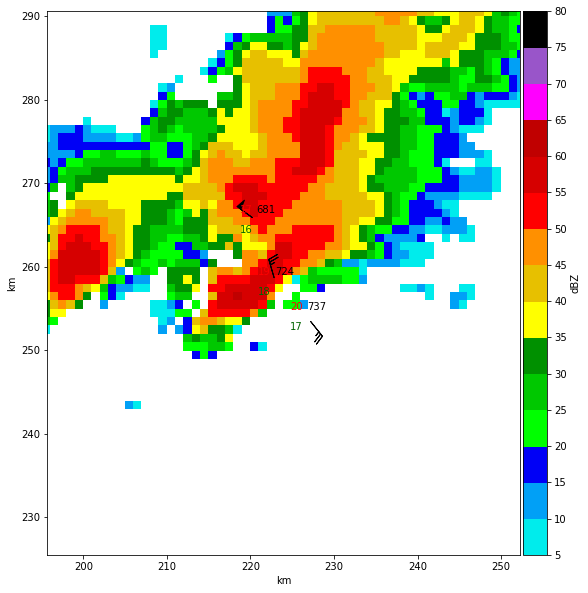

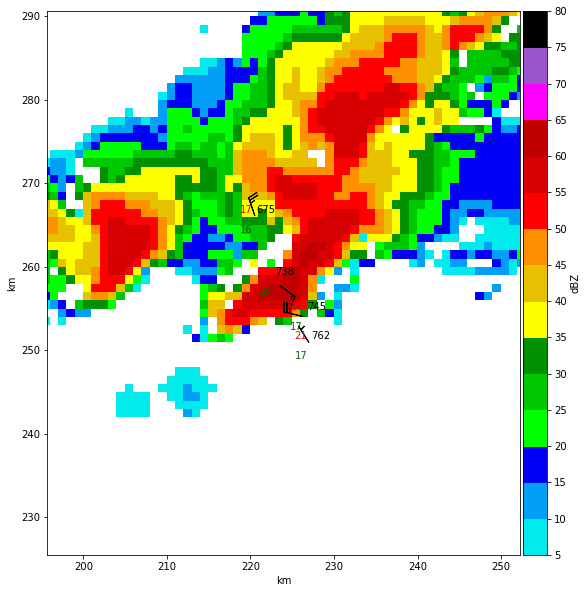

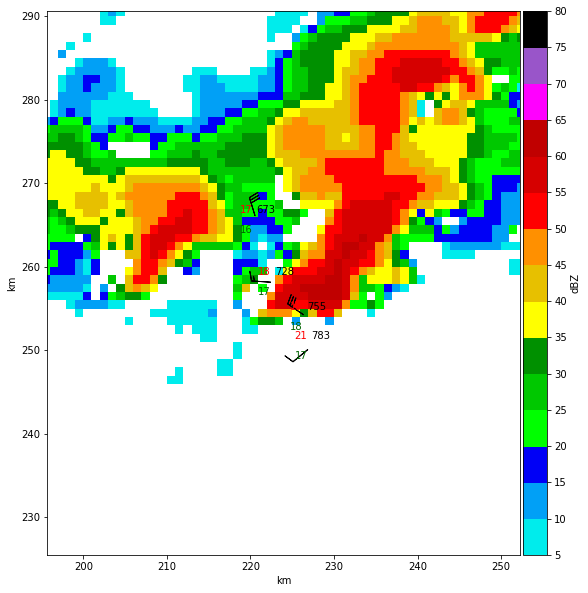

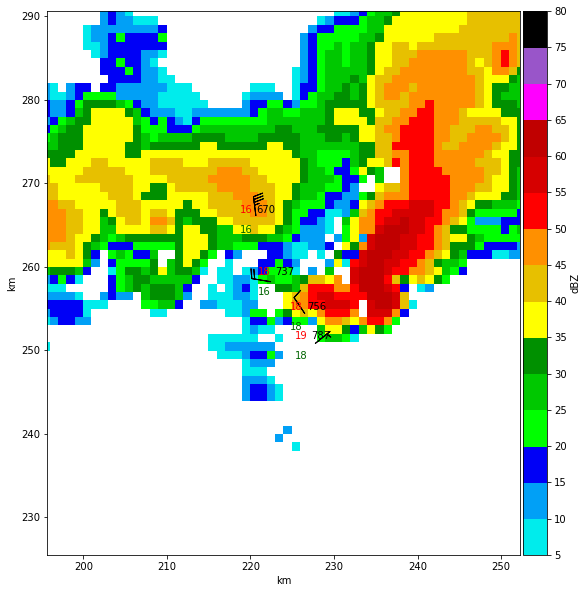

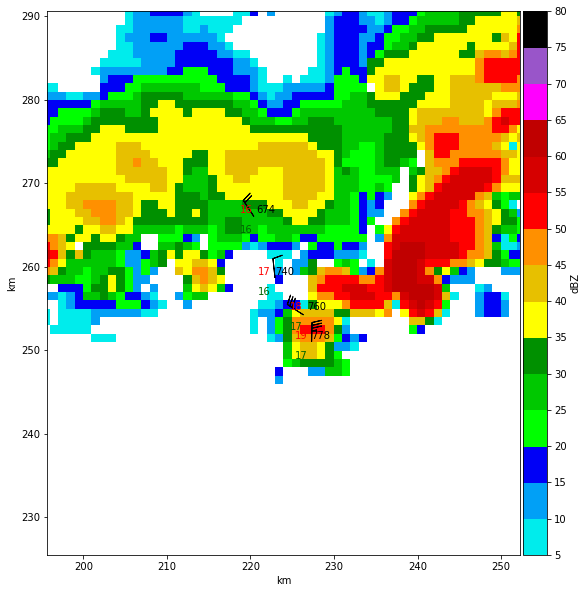

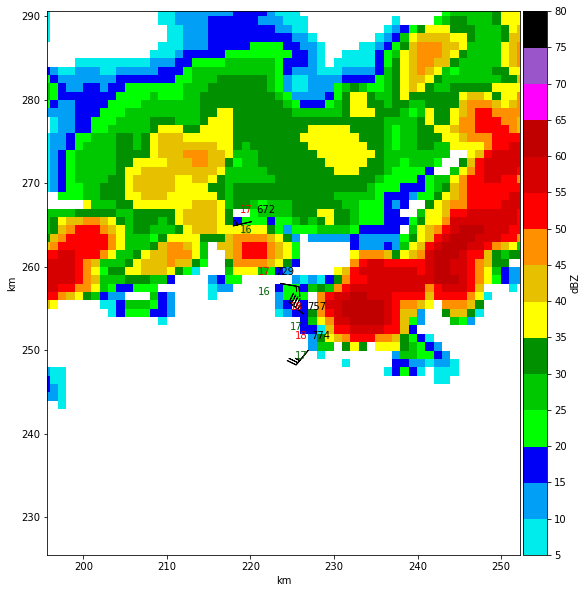

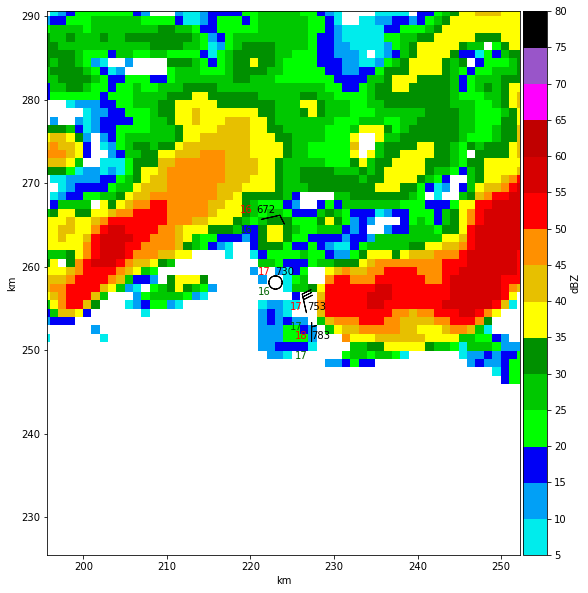

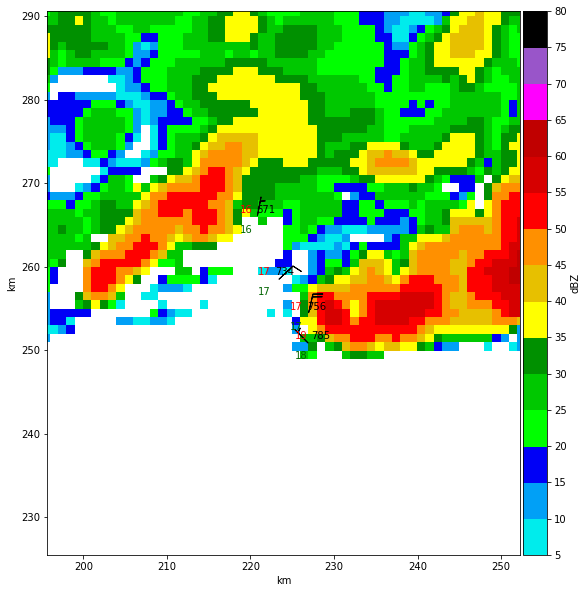

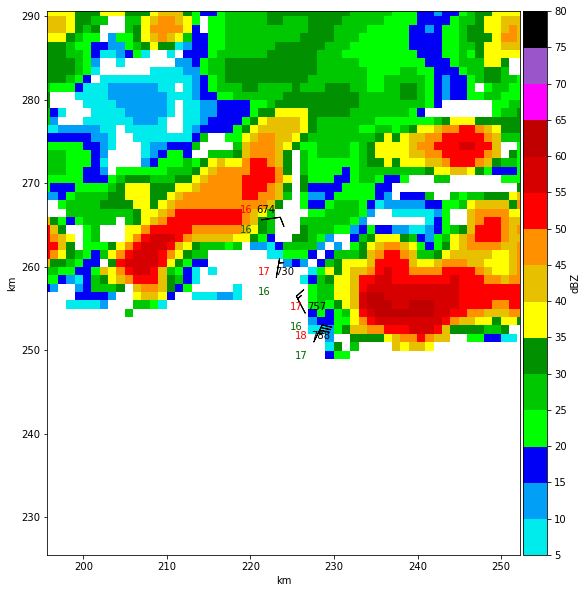

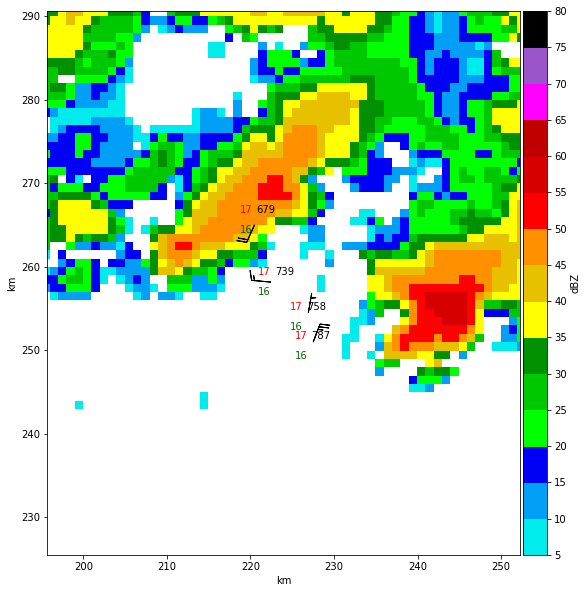

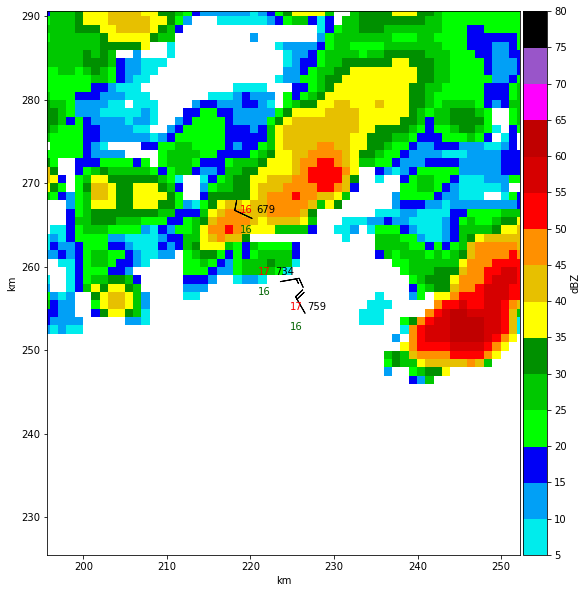

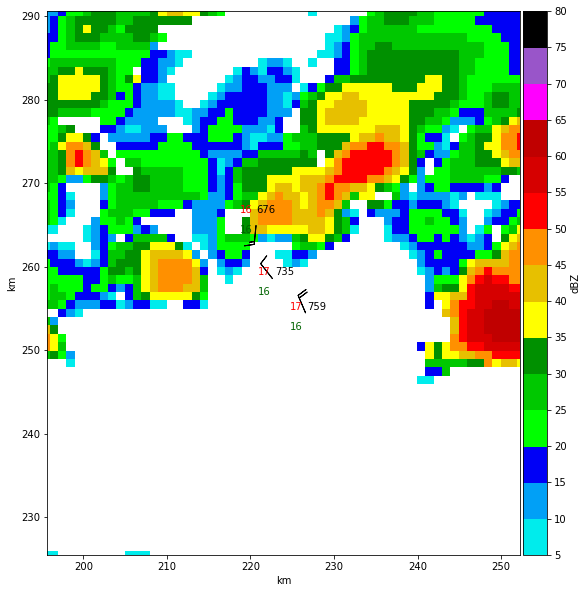

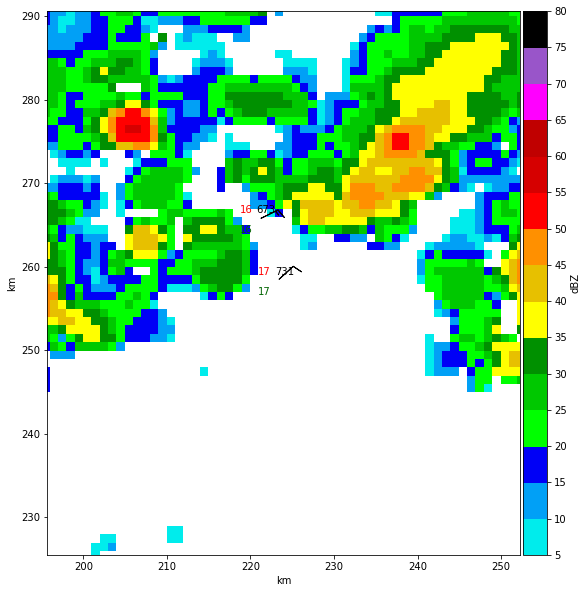

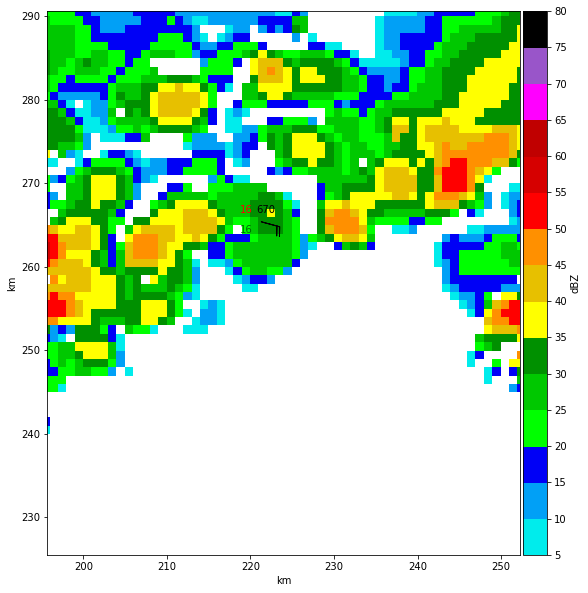

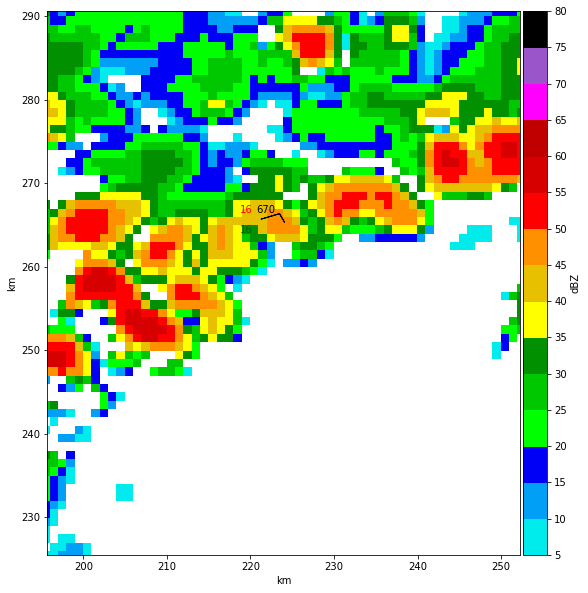

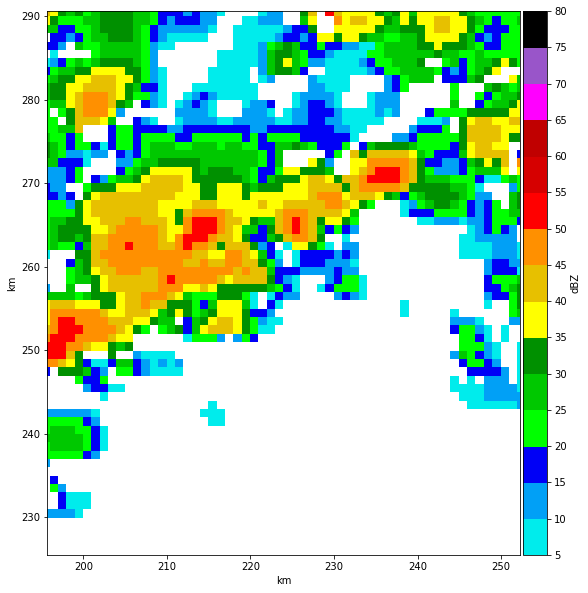

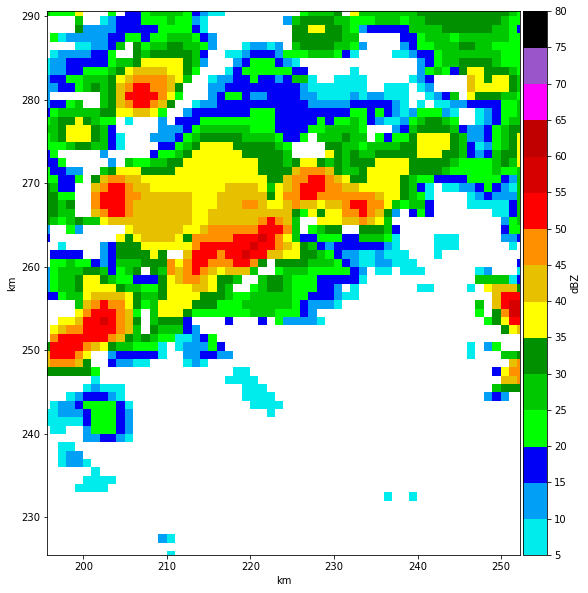

In [11]:
# Plot the PIPS station models on the ARPS model grid, similar to what was done with the radar sweep files
dilist = [i[0] for i in dis_dict['dmodcrdlist']]
djlist = [i[1] for i in dis_dict['dmodcrdlist']]

print(dilist)
print(djlist)

dxlist = [i[0] for i in dis_dict['dmodloclist']]
dylist = [i[1] for i in dis_dict['dmodloclist']]

print(dxlist)
print(dylist)

xc = grid_dict['xs']
yc = grid_dict['ys']
xe = grid_dict['x']
ye = grid_dict['y']

xckm = xc / 1000.
yckm = yc / 1000.
xekm = xe / 1000.
yekm = ye / 1000.

# Set plotting limits to center on the disdrometer locations 

Dxmin = min(dxlist)
Dxmax = max(dxlist)
Dymin = min(dylist)
Dymax = max(dylist)
plotlims = [Dxmin - 25000., Dxmax + 25000., Dymin - 25000., Dymax + 25000.]

ibgn = np.searchsorted(xc, plotlims[0])
iend = np.searchsorted(xc, plotlims[1]) + 1
jbgn = np.searchsorted(yc, plotlims[2])
jend = np.searchsorted(yc, plotlims[3]) + 1

print(plotlims)
print(ibgn, iend, jbgn, jend)

plotvar_dict = {
    'xcplt': xckm,
    'ycplt': yckm,
    'xeplt': xekm,
    'yeplt': yekm,
}

plotparam_dict = {
    'cmap': pyPIPSradar.cmapdBZ,
    'fieldlevels': np.arange(5.0, 85.0, 5.0),
    'clvls': matplotlib.ticker.MultipleLocator(base=5.0),
    'clabel': r'dBZ',
    'cformat': None,
}

plotparam_dict['norm'] = matplotlib.colors.BoundaryNorm(plotparam_dict['fieldlevels'], 
                                                        plotparam_dict['cmap'].N)

axesparam_dict = {
    'axis_ticks': (10000., 10000.),
    'axis_names': ('x', 'y')
}

plotlim_dict = {
    'x': (plotlims[0], plotlims[1]),
    'y': (plotlims[2], plotlims[3])
}

plotvar_name = 'dBZmod'


dis_dict_at_model = sim.read_convdata_at_modeltimes(init_dis_dict, model_dict)

# Extract stuff from disdrometer dictionary
templist = dis_dict_at_model['convdata_at_modeltimes']['temp']
dewpointlist = dis_dict_at_model['convdata_at_modeltimes']['dewpoint']
pressurelist = dis_dict_at_model['convdata_at_modeltimes']['pressure']
windspdavgveclist = dis_dict_at_model['convdata_at_modeltimes']['windspdavgvec']
winddiravgveclist = dis_dict_at_model['convdata_at_modeltimes']['winddiravgvec']

print(templist)

for i, time in enumerate(model_trange_sec):
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=time, filetype='history')
    print(filepath)
    
    var_read_dict = {}
    var_read_dict = pycaps_fields.get_fields(var_read_dict, field_names=[plotvar_name], path_grdbas=grdbas_path, 
                                             path_hdf=filepath, ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend, 
                                             klvls=[2], multipatch=True, grid_dict=grid_dict, 
                                             ignore_existing_vars=True)
    
    plotvar_dict = plotmod.init_plotvar_dict(plotvar_name, var_read_dict[plotvar_name], 0, 1, grid_dict)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plotmod.plot2D(fig, ax, 'pcolor', plotvar_dict, plotparam_dict)
    
    plotmod.set_plot_axes(ax, plotlim_dict, axesparam_dict)

    for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
        stationplot = StationPlot(ax, [Dx], [Dy])
        stationplot.plot_parameter('NW', [templist[j][i]], color='red')
        stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
        stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
        u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
        stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))
    
    figname = 'PIPS_station_model_{}.png'.format(model_datetime_range[i].strftime('%Y%m%d%H%M%S'))
    figpath = os.path.join(plotdir, figname)
    plt.savefig(figpath, dpi=300, bbox_inches='tight') 
    
# figlist, gridlist = pyPIPSradar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[i], ovrmap, 
#                                                     ovrdis, dis_name_list, dxy_list, fields_D_list)
#     ax = gridlist[0][0]
    
#     for j, Dx, Dy in zip(range(len(dxlist)), dxlist, dylist):
#         stationplot = StationPlot(ax, [Dx], [Dy])
#         stationplot.plot_parameter('NW', [templist[j][i]], color='red')
#         stationplot.plot_parameter('SW', [dewpointlist[j][i]], color='darkgreen')
#         stationplot.plot_parameter('NE', [pressurelist[j][i]], formatter=lambda v: format(10 * v, '.0f')[-3:])
#         u, v = get_wind_components([windspdavgveclist[j][i]] * units('m/s'), [winddiravgveclist[j][i]] * units.degree)
#         stationplot.plot_barb(u, v, barb_increments=dict(half=0.5, full=1.0, flag=5.0))

#     figlist[0].canvas.draw()
#     figlist[0].set_size_inches(10., 10., forward = True)
#     figname = 'PIPS_station_{}.png'.format(sweeptime.strftime('%Y%m%d%H%M%S'))
#     figpath = os.path.join(plotdir, figname)
#     plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [23]:
import pyPIPS.io as pips_io
# Read in PIPS data

print(dis_dict.keys())

dis_dir = dis_dict['dis_dir']
dis_filenames = dis_dict['disfilenames']
dis_names = dis_dict['dis_names']

conv_df_dict = {}
parsivel_df_dict = {}
vd_matrix_da_dict = {}

for dis_filename, dis_name in zip(dis_filenames, dis_names):
    dis_filepath = os.path.join(dis_dir, dis_filename)
    print("Reading {}".format(dis_filepath))
    conv_df, parsivel_df, vd_matrix_da = pips_io.read_PIPS(dis_filepath, starttimestamp=timestamp_start,
                                                           stoptimestamp=timestamp_stop)
    # Calculate some additional thermodynamic quantities and add to the conventional data DataFrame
    conv_df = pips.calc_thermo(conv_df)
    conv_df_dict[dis_name] = conv_df
    parsivel_df_dict[dis_name] = parsivel_df
    vd_matrix_da_dict[dis_name] = vd_matrix_da_dict

dict_keys(['dis_dir', 'dis_types', 'dis_names', 'disfilenames', 'convfilenames', 'starttimes', 'stoptimes', 'interval', 'convdata_at_sweeptimes', 'dgeoloclist', 'dradloclist', 'dmodloclist', 'dmodcrdlist', 'convdata_at_modeltimes'])
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_1A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_1B_IOP_3_D1.txt
GPS time: Thu Mar 31 22:01:33 2016, Logger time: Thu Mar 31 22:01:30 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_2A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:25:03 2016, Logger time: Thu Mar 31 22:25:00 2016
GPS Offset: 0:00:03
Reading /Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/IOP3/PIPS_2B_IOP_3_D1.txt
GPS t

In [24]:
# Resample conventional data to a 60-s interval and plot it
conv_rs_df_dict = {}
for dis_name in dis_names:
    conv_df = conv_df_dict[dis_name]
    datetime_range_onesec = conv_df.index.to_pydatetime()
    sec_offset = pips.get_offset_seconds(datetime_range_onesec)
    conv_rs_df_dict[dis_name] = pips.resample_conv('PIPS', 60., sec_offset, conv_df)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


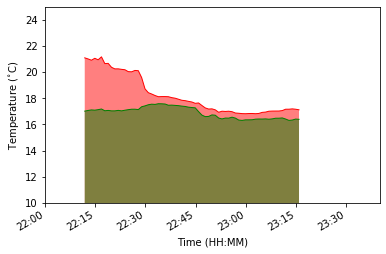

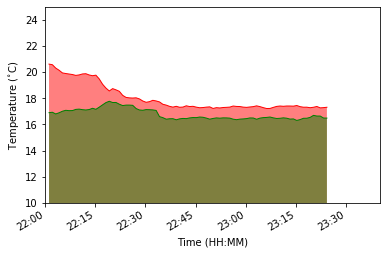

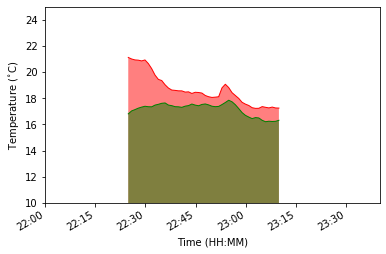

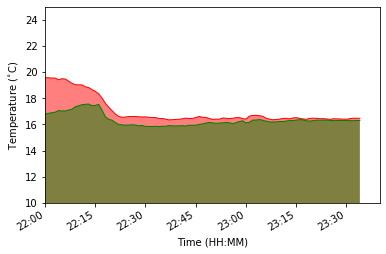

In [25]:
dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = None
timelabel = 'Time (HH:MM)'
xaxislimits = [dates.date2num(datetime_range[0]), dates.date2num(datetime_range[-1])]
meteo_T_Td_range = [10., 25.]

for i, dis_name in enumerate(dis_names):
    conv_rs_df = conv_rs_df_dict[dis_name]
    datetimes_PIPS_conv = conv_rs_df.index.to_pydatetime()
    plottimes = dates.date2num(datetimes_PIPS_conv)
    T_PIPS = conv_rs_df['fasttemp']
    Td_PIPS = conv_rs_df['dewpoint']
   
    fig, ax = plt.subplots()
    fields = [T_PIPS, Td_PIPS]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)

In [29]:
# Read in potential temperature, pressure, and water vapor specific humidity from a series of arps files 
# and interpolate them to the PIPS locations, building up a time series.
T_model = []
Td_model = []
pte_model = []
print(ibgn, iend, jbgn, jend)
print(model_dict.keys())

vardict_list = []

for time in model_dict['trange']:
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(member_absdir, member_prefix, fileformat, time=time, filetype='history')
    vardict = arps_read.read_hdfvars(filepath, ['p', 'pt', 'qv'], ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend)
    vardict_list.append(vardict)

#     #
    
#     p = vardict['p']
#     pt = vardict['pt']
#     qv = vardict['qv']
    
#     p_atPIPS = ndimage.map_coordinates(p[..., 1], coord_array, order=1)
#     pt_atPIPS = ndimage.map_coordinates(pt[..., 1], coord_array, order=1)
#     qv_atPIPS = ndimage.map_coordinates(qv[..., 1], coord_array, order=1)
    
# #     print p_atPIPS
# #     print pt_atPIPS
# #     print qv_atPIPS
    
#     T_atPIPS = thermo.calT(p_atPIPS, pt_atPIPS)-273.15
#     Td_atPIPS = thermo.calTd(p_atPIPS, qv_atPIPS)-273.15
#     pte_atPIPS = thermo.calpte(p_atPIPS, pt_atPIPS, qv_atPIPS)
    
#     #print T_atPIPS
    
#     T_model.append(T_atPIPS)
#     Td_model.append(Td_atPIPS)
#     pte_model.append(pte_atPIPS)

197 254 226 293
dict_keys(['runname', 'nens', 'fileformat', 'microphys', 'model_dt', 'model_dt_mean', 'basedirname', 'timestamp_model_init', 'timestamp_model_start', 'timestamp_model_stop', 'trange_member', 'trange_mean', 'datetime_range_member', 'datetime_range_mean', 'trange', 'datetime_range'])
Loading time  14400.0
Loading time  14700.0
Loading time  15000.0
Loading time  15300.0
Loading time  15600.0
Loading time  15900.0
Loading time  16200.0
Loading time  16500.0
Loading time  16800.0
Loading time  17100.0
Loading time  17400.0
Loading time  17700.0
Loading time  18000.0
Loading time  18300.0
Loading time  18600.0
Loading time  18900.0
Loading time  19200.0
Loading time  19500.0
Loading time  19800.0
Loading time  20100.0
Loading time  20400.0


In [66]:
import xarray as xr
zc = grid_dict['zs']
zc = zc.T
xc_patch = xc[ibgn:iend+1]
yc_patch = yc[jbgn:jend+1]
zc_patch = zc[:, jbgn:jend+1, ibgn:iend+1]
# First, create a dict of lists out of the above list of dicts
vardict_combined = CRMutils.make_dict_of_lists(vardict_list)
# Set things up for creating the xr Dataset
for varname, var in vardict_combined.items():
    var_arr = np.rollaxis(np.array(var).T, 3, 0)
    # Trim variables down to just the patch we want to work with
    var_arr_patch = var_arr[:, :, jbgn:jend+1, ibgn:iend+1]
    vardict_combined[varname] = (['time', 'z', 'yc', 'xc'], var_arr_patch)

coord_dict = {'time': model_dict['datetime_range'],
              'zc': (['z', 'yc', 'xc'], zc_patch),
              'yc': ('yc', yc_patch),
              'xc': ('xc', xc_patch)}
# Create an xarray Dataset out of the variable dictionary
var_ds = xr.Dataset(vardict_combined, coords=coord_dict)
var_ds

<xarray.Dataset>
Dimensions:  (time: 21, xc: 58, yc: 68, z: 53)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:00:00 ... 2016-03-31T23:40:00
    zc       (z, yc, xc) float32 173.66124 165.5462 ... 21154.0 21153.758
  * yc       (yc) float32 225500.0 226500.0 227500.0 ... 291500.0 292500.0
  * xc       (xc) float32 196500.0 197500.0 198500.0 ... 252500.0 253500.0
Dimensions without coordinates: z
Data variables:
    p        (time, z, yc, xc) float32 98151.97 98246.12 ... 5173.2305 5173.6284
    pt       (time, z, yc, xc) float32 298.63275 298.62463 ... 490.44644
    qv       (time, z, yc, xc) float32 0.014203909 0.013995732 ... 1.0133435e-05

In [67]:
# Save Dataset to nc file
savedir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/nc'
if not os.path.exists(savedir):
    os.makedirs(savedir)
filename = "{}_thermo_fields.nc".format(member_prefix)
filepath = os.path.join(savedir, filename)
var_ds.to_netcdf(filepath)

In [71]:
var_interp_list = []
x_coords = [a[0] for a in dis_dict['dmodloclist']]
y_coords = [a[1] for a in dis_dict['dmodloclist']]

x_coords_da = xr.DataArray(x_coords, dims='points')
y_coords_da = xr.DataArray(y_coords, dims='points')

for varname in var_ds.data_vars.keys():
    var_da = var_ds[varname]
    var_interp = var_da.interp(xc=x_coords_da, yc=y_coords_da)
    print(var_interp.isel(z=1))
    var_interp_list.append(var_interp)
    

<xarray.DataArray 'p' (time: 21, points: 4)>
array([[97368.598423, 97103.630676, 97405.006758, 96652.64915 ],
       [97292.317726, 96988.636012, 97358.451888, 96504.554956],
       [97348.356386, 97131.54695 , 97380.241525, 96719.797166],
       [97308.811393, 97057.581781, 97360.228609, 96726.893505],
       [97084.494741, 97059.910857, 97181.214916, 96756.356896],
       [97510.680154, 97350.437995, 97447.217494, 96814.17945 ],
       [97494.748584, 97239.775333, 97441.8309  , 96797.33902 ],
       [97272.591855, 97100.174983, 97252.177636, 96738.339103],
       [97567.065177, 97313.83696 , 97582.302355, 96819.682899],
       [97504.055845, 97238.253765, 97505.483494, 96741.007912],
       [97421.161812, 97174.35836 , 97424.858701, 96768.787883],
       [97412.762661, 97146.285682, 97446.903009, 96656.21543 ],
       [97460.277847, 97213.309297, 97500.87585 , 96770.315176],
       [97221.487153, 96992.72463 , 97240.349042, 96549.511609],
       [97461.410503, 97227.025943, 97466.246

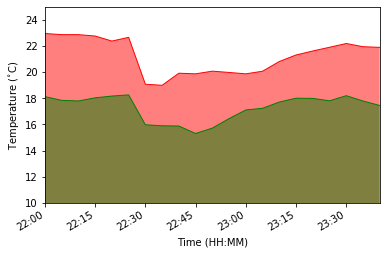

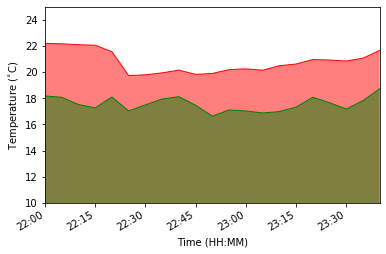

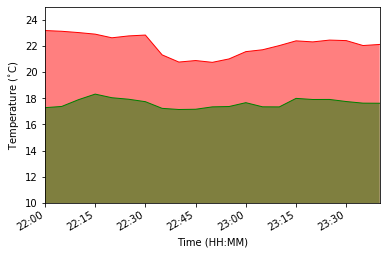

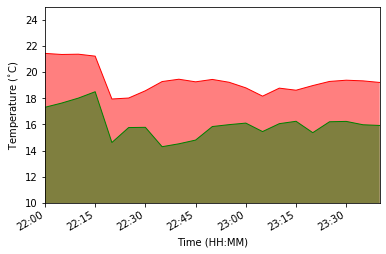

In [79]:
p_interp = var_interp_list[0].isel(z=1)
pt_interp = var_interp_list[1].isel(z=1)
qv_interp = var_interp_list[2].isel(z=1)

T_model_PIPS = thermo.calT(p_interp, pt_interp) - 273.15
Td_model_PIPS = thermo.calTd(p_interp, qv_interp) - 273.15


dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
plottimes = dates.date2num(datetime_range)
xaxislimits = [plottimes[0], plottimes[-1]]
meteo_T_Td_range = [10., 25.]

for i, PIPSname in enumerate(dis_dict['dis_names']):
    #print i
    fig, ax = plt.subplots()
    T_model_PIPS_plt = T_model_PIPS.isel(points=i)
    Td_model_PIPS_plt = Td_model_PIPS.isel(points=i)
    fields = [T_model_PIPS_plt, Td_model_PIPS_plt]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)


# Old Cells Below!

In [ ]:
# Make a plot of the disdrometer transects through the storm, 
# choosing a representative sweeptime as the backdrop
plotdir = '/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/plots/'+casedate
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
# If there is no reference sweeptime in the dictionary, just use the first one
sweeptimeref = radar_dict[casedate]['sweeptime_ref']
ustorm, vstorm = radar_dict[casedate]['feature_motion']
sweepindex = np.searchsorted(sweeptimelist, sweeptimeref)
sweepdtrel = [(sweeptime - sweeptimeref).total_seconds() for sweeptime in sweeptimelist]
deployed = dis_dict_at_radar[casedate]['convdata_at_sweeptimes']['deployed']
# dxsr = [[dx - ustorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dx, dp in zip(dxlist, deployed)]
# dysr = [[dy - vstorm * dt if d else np.nan for dt, d in zip(sweepdtrel, dp)] for dy, dp in zip(dylist, deployed)]
dxsr = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxlist]
dysr = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dylist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsr_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsr, deployed)]
dxsr_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsr, deployed)]
dysr_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysr, deployed)]
dysr_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysr, deployed)]

print sweeptimelist
print sweepindex
print deployed[0]
print dxsr[0]
print dxsr_d[0]
print dxsr_nd[0]

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.nanmin(np.array(dxsr))
Dxmax = np.nanmax(np.array(dxsr))
Dymin = np.nanmin(np.array(dysr))
Dymax = np.nanmax(np.array(dysr))
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]
# plotlims = [15000., 45000., -15000., 0.]

figlist, gridlist = radar.plotsweep_pyART(radlims, plotlims, outfieldnames, radarsweeplist[sweepindex], ovrmap, 
                                              ovrdis, dis_name_list, dxy_list, fields_D_list)
ax = gridlist[0][0]

dis_names = dis_dict_at_radar[casedate]['dis_names']

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxlist)), dxsr, dysr, dxsr_d, dysr_d, 
                                                          dxsr_nd, dysr_nd, deployed, dis_names):
    ax.plot(dx_d, dy_d, ls='-', c='k')
    ax.plot(dx, dy, ls='--', c='k')
    if dp[sweepindex]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)

gridlist[0].cbar_axes[0].set_ylabel('Z (dBZ)')
ax.set_xlabel('km')
ax.set_ylabel('km')
    
figlist[0].canvas.draw()
figlist[0].set_size_inches(10., 10., forward = True)

figpath = os.path.join(plotdir, casedate+'_transects_radar.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Set up stuff for time composites
# Initial grid limits (m)
gridlims = [0., 100000., 0., 100000.]

# Width of composite box in m
compositewidthx = 60000.
compositewidthy = 60000.

# Width of search box for extremum in m
searchboxwidthx = 12000.
searchboxwidthy = 12000.

# Name of variable for whose extrema to track for compositing (that's an awkward phrasing)
tracking_varname = 'vortz'
# level (height in m) at which to track the extrema
tracking_level = 0.0 # 0.0 for 5 June, 3000.0 for 7 June, 3000.0 for 9 June 
# Type of extremum (max or min)
tracking_extremum = 'max'
# Threshold magnitude of extremum below which to throw out a time from the composite
tracking_thresh = 0.01

compositedict = {'gridlims': gridlims,
                 'compositewidth': (compositewidthx, compositewidthy), 
                 'searchboxwidth': (searchboxwidthx, searchboxwidthy),
                 'tracking_varname': tracking_varname,
                 'tracking_extremum': tracking_extremum, 
                 'tracking_level': tracking_level, 
                 'tracking_thresh': tracking_thresh}

# Read in the model information for the case we want
model_dict = sim.set_dh(casedate, init_model_dict, radar_dict)
dh = model_dict[casedate]['DataHandler']
modeltime_ref = model_dict[casedate]['modeltime_ref']

# Read in the model grid info
grid_dict = sim.read_model_grid(dh)
# Initialize composite parameters
if model_dict[casedate]['composite']:
    compositedict = sim.init_composite(compositedict, grid_dict)

# dp_data, consts = dh.loadMicrophysics()
# # Extract the lowest model level and store in dp_data_2D
# dp_data_2D = {}
# for key, dat in dp_data.iteritems():
#     dp_data_2D[key] = dat[:,:,0]
# dp_data_plot = {}
# for key, dat in dp_data_2D.iteritems():
#     dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
# dp_data_plot_list.append(dp_data_plot)

if model_dict[casedate]['composite']:
    print "Building composite!"
    varcompdict = sim.build_composite(casedate, model_dict, compositedict, dh)
    Zmod = varcompdict['DBZ']
    Zmodplot = Zmod
else:    
    Zmod = dh.loadModelReflectivity()
    Zmodplot = Zmod[:, :, 0].T
# Zmodplot_list.append(Zmodplot)

In [ ]:
# Quick plot of the reflectivity composite for testing
runname = model_dict[casedate]['runname']
model_times = model_dict[casedate]['model_times']
xckm_comp, yckm_comp = compositedict['ccoords']
uccomp = varcompdict['UC']
vccomp = varcompdict['VC']
wind_pltscale = 2.0 # Scale of wind vectors
windintv = 4        # Interval in grid points to plot wind vectors

clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
# qrplot = varcompdict['qg']*1000.
# clevels = np.arange(0., 5.05, 0.05)
# cintv = clevels[1] - clevels[0]
# norm = None
# cmap = cm.Blues
# cbarlevels = np.arange(0., 5.5, 0.5) # ticker.MultipleLocator(base=1.0)
# clabel = 'qg (g/kg)'

compfig = plt.figure(figsize=(8,8))
compax = compfig.add_subplot(111)
plt.title(model_dict[casedate]['runname'])
dBZplt = compax.contourf(xckm_comp, yckm_comp, Zmodplot, levels=clevels, cmap=cmap)
# compax.contour(xskm_comp,yskm_comp,dBZ.T,levels=np.arange(30.,90.,10.),colors='k')
windplt = compax.quiver(xckm_comp[::windintv], yckm_comp[::windintv], uccomp[::windintv, ::windintv],
    vccomp[::windintv, ::windintv], pivot='middle', units='width', scale_units='width', 
    scale=1200.0/float(wind_pltscale), width=0.001*float(wind_pltscale), headwidth=5, headlength=5, color='k')

compax.set_aspect('equal')
divider = make_axes_locatable(compax)
cax = divider.append_axes("right", size="5%", pad = 0.05)
clabels = cbarlevels
clvllocator = ticker.FixedLocator(clabels)
plt.colorbar(dBZplt, ticks=clvllocator, cax=cax)
cax.set_ylabel('Z (dBZ)')
#cax.set_ylabel('qg (g/kg)')

compax.set_xlabel('km')
compax.set_ylabel('km')

compfig.savefig(runname+'_dBZ_comp_{:06d}_{:06d}.pdf'.format(int(model_times[0]),int(model_times[-1])),dpi=200)

In [ ]:
# Make a plot of the disdrometer transects through the *simulated* storm, 
# choosing a representative *model time* as the backdrop

# First we need to set up a list of x and y coordinates within the model for each disdrometer. We'll use the
# coordinates computed relative to the radar above, but shifted so that they are in the same relative position
# to the model storm (necessarily subjective) as they are for the observed storm.
# For example, we'll use P2's coordinates near the tip of the hook for 5 June 2009.

if model_dict[casedate]['composite']:
    xref_model, yref_model = model_dict[casedate]['ref_coords_comp']
    # Some coordinate array shenanigans
    composite_grid_dict = sim.get_composite_grid(grid_dict, compositedict)
    xcplot = composite_grid_dict['xcplot']
    ycplot = composite_grid_dict['ycplot']
    xeplot = composite_grid_dict['xeplot']
    yeplot = composite_grid_dict['yeplot']
    xcorplot = composite_grid_dict['xcorplot']
    ycorplot = composite_grid_dict['ycorplot']
else:
    xref_model, yref_model = model_dict[casedate]['ref_coords']
    xcplot = grid_dict['xcplot']
    ycplot = grid_dict['ycplot']
    xeplot = grid_dict['xeplot']
    yeplot = grid_dict['yeplot']
    xcorplot = grid_dict['xcorplot']
    ycorplot = grid_dict['ycorplot']

xref_rad = dxlist[-1]
yref_rad = dylist[-1]

xshift = xref_model - xref_rad
yshift = yref_model - yref_rad

dxmodlist = [dx + xshift for dx in dxlist]
dymodlist = [dy + yshift for dy in dylist]

# Using sweeptimelist here to facilitate matching with the disdrometer locations on the radar plot.
sweepdtrel = [(sweeptime - modeltime_ref).total_seconds() for sweeptime in sweeptimelist]
dxsrm = [[dx - ustorm * dt for dt in sweepdtrel] for dx in dxmodlist]
dysrm = [[dy - vstorm * dt for dt in sweepdtrel] for dy in dymodlist]

# Split up disdrometer storm relative locations by whether the disdrometer was actually deployed at a given time
dxsrm_d = [[x for x, d in zip(dx, dp) if d] for dx, dp in zip(dxsrm, deployed)]
dxsrm_nd = [[x for x, d in zip(dx, dp) if not d] for dx, dp in zip(dxsrm, deployed)]
dysrm_d = [[y for y, d in zip(dy, dp) if d] for dy, dp in zip(dysrm, deployed)]
dysrm_nd = [[y for y, d in zip(dy, dp) if not d] for dy, dp in zip(dysrm, deployed)]

# Get the index where the relative time is zero. Use this below to put the probes
# at the proper location along the transect corresponding to the reference time.
modelindex_ref = np.searchsorted(sweepdtrel, 0.)

# Set plotting limits to center on the disdrometer locations 
Dxmin = np.array(dxsrm).min()
Dxmax = np.array(dxsrm).max()
Dymin = np.array(dysrm).min()
Dymax = np.array(dysrm).max()
plotlims = [Dxmin - 5000., Dxmax + 10000., Dymin - 10000., Dymax + 10000.]

fig = None
ax = None
ptype = 2
xlim = [plotlims[0], plotlims[1]]
ylim = [plotlims[2], plotlims[3]]
clevels = np.arange(0., 85., 5.)
cintv = clevels[1] - clevels[0]
norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 5., 5.)
cbarlevels = ticker.MultipleLocator(base=cintv)
clabel = 'Z (dBZ)'
cformat = None
ovrmap = False
gis_info = None
numovr = 0
axesticks = [10000., 10000.]

fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                            cbarlevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                            axesticks)

for j, dx, dy, dx_d, dy_d, dx_nd, dy_nd, dp, dname in zip(xrange(len(dxmodlist)), dxsrm, dysrm, dxsrm_d, dysrm_d, 
                                                          dxsrm_nd, dysrm_nd, deployed, dis_names):
    ax.plot(dx, dy, ls='--', c='k')
    ax.plot(dx_d, dy_d, ls='-', c='k')
    if dp[modelindex_ref]:
        marker = 'o'
    else:
        marker = 'x'
    ax.plot(dx[sweepindex], dy[sweepindex], marker=marker, ms=10, c='k')
    ax.annotate(dname, (dx[sweepindex] + 1000., dy[sweepindex] - 2000.), clip_on=True)
    
fig.canvas.draw()
fig.set_size_inches(10., 10., forward = True)
figpath = os.path.join(plotdir, casedate+'_transects_model.eps', bbox_inches='tight')
plt.savefig(figpath, dpi=300)

In [ ]:
# Read in time series and add to dis_dict
dis_dict = sim.read_probe_time_series(casedate, dis_dict, radar_dict)


In [ ]:
if not model_dict[casedate]['composite']:
    varlists = ['DBZ', 'TH', 'QV', 'P']
    varlistv = ['U', 'V']
    varlist_derived = ['PTE', 'UC', 'VC']

    vardictlist = sim.read_vardict(casedate, model_dict, varlists, varlistv, varlist_derived)

    vardict = vardictlist[0]
    grid_dict_in = grid_dict
else:
    vardict = varcompdict
    grid_dict_in = composite_grid_dict

# Find grid intersections
dis_ts_model_dict = sim.find_transect_grid_intersections(casedate, grid_dict_in, dis_dict, model_dict, radar_dict, 
                                     vardict, plot_locations=False, debug=False)

In [ ]:
print dis_dict[casedate].keys()
print dis_ts_model_dict.keys()
print varcompdict['rhoa']
dis_ts_vars_points = dis_ts_model_dict['dis_ts_vars_points']
print len(dis_ts_vars_points)
dis_names = dis_dict[casedate]['dis_names']
print len(dis_names)

In [ ]:
print dis_dict[casedate]['timeseries'].keys()

In [ ]:
# Calculate and plot observed DSD transects
transect_DSD_obs_dict = sim.calc_obs_transect(casedate, dis_dict, dis_ts_model_dict, Dmax=9.0, plot_transects=True)

In [ ]:
# Calculate and plot model DSD transects
transect_DSD_dict = sim.interp_model_to_transect(casedate, dis_dict, model_dict, dis_ts_model_dict,
                                                 sampling_interval=60., add_hail=False, 
                                                 use_bins_for_interp=True, use_Parsivel_simulator=True, 
                                                 Dmax=9.0, plot_transects=True)

In [ ]:
# Make some one-to-one plots of D0 (model) vs. D0 (disdrometer)

yvals = sim.D*1000.
xvals = sim.D*1000.
color_list = ['r', 'orange', 'g', 'b']

D0r_mod = transect_DSD_dict['D0r']
D0r_mod_sampled = transect_DSD_dict['D0r_ps']

D0r_obs = transect_DSD_obs_dict['D0r_obs']
D0r_obs_gam = transect_DSD_obs_dict['D0r_gam']

for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    obs = D0r_obs_gam[d]*1000.
    mod = D0r_mod[d]*1000.
    mod_sampled = D0r_mod_sampled[d]*1000.
    bias_mod = ((np.nansum(mod-obs))/np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled-obs))/np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 8.0)
    ax.set_ylim(0.0, 8.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')

In [ ]:
# Calculate dual-pol variables for both the model and observations and make scatterplots of Z vs. ZDR
# Z, ZDR relation from Cao et al. (2008)
Zh_Cao = np.arange(10, 61, 0.1)
Zdr_Cao = 10**((-2.6857 * 10**-4 * Zh_Cao**2) + 0.04892 * Zh_Cao - 1.4287)

scattfile = '../tmatrix/S-band/SCTT_RAIN_fw100.dat'
wavelength = 10.7 # mm
Dmax = 9.0
Dmax_index = sim.get_Dmax_index(Dmax)
color_list = ['r', 'orange', 'g', 'b']
ND_mod = transect_DSD_dict['ND']
ND_obs = transect_DSD_obs_dict['ND']



for d, dis_name in enumerate(dis_dict[casedate]['dis_names']):
    dualpol_mod = dis.calpolrain(wavelength, scattfile, ND_mod[d].T, dis.bin_width[:Dmax_index])
    dualpol_obs = dis.calpolrain(wavelength, scattfile, ND_obs[d].T, dis.bin_width[:Dmax_index])
    sample_xlocs = np.array([xylocs[0] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    print sample_xlocs
    sample_ylocs = np.array([xylocs[1] for xylocs in dis_ts_model_dict['dis_ts_xyslocs'][d]])
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sc = plt.scatter(dualpol_mod['dBZ'], dualpol_mod['ZDR'], c=sample_xlocs, marker='*', label=dis_name+'_mod',
                     vmin=-15000., vmax=15000.)
    plt.scatter(dualpol_obs['dBZ'], dualpol_obs['ZDR'], c=sample_xlocs, marker='o', label=dis_name+'_obs', vmin=-15000., vmax=15000.)
    plt.plot(Zh_Cao, Zdr_Cao, c='k', ls='-', lw=1.0)
    plt.colorbar(sc)
    ax.set_xlabel('dBZ')
    ax.set_ylabel(r'Z$_DR$')
    ax.set_xlim(10.0, 60.0)
    ax.set_ylim(-2.0, 6.0)
    plt.legend(loc='upper left')